In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vinbigdatachestxrayabnormalities512x512jp2/vinbigdata-chest-xray-abnormalities-detection-512x512-jp2/sample_submission.csv
/kaggle/input/vinbigdatachestxrayabnormalities512x512jp2/vinbigdata-chest-xray-abnormalities-detection-512x512-jp2/train_meta.csv
/kaggle/input/vinbigdatachestxrayabnormalities512x512jp2/vinbigdata-chest-xray-abnormalities-detection-512x512-jp2/train.csv
/kaggle/input/vinbigdatachestxrayabnormalities512x512jp2/vinbigdata-chest-xray-abnormalities-detection-512x512-jp2/test.csv
/kaggle/input/vinbigdatachestxrayabnormalities512x512jp2/vinbigdata-chest-xray-abnormalities-detection-512x512-jp2/test/ee24bfc8651524e8efeee45ff30cb532.jp2
/kaggle/input/vinbigdatachestxrayabnormalities512x512jp2/vinbigdata-chest-xray-abnormalities-detection-512x512-jp2/test/293df7b3db7c3d58656e9169abffce81.jp2
/kaggle/input/vinbigdatachestxrayabnormalities512x512jp2/vinbigdata-chest-xray-abnormalities-detection-512x512-jp2/test/fa1f952dd2567c9e516cae5a59c30692.jp2
/kaggle/input

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Train CSV shape:", train_df.shape)
print(train_df.head())

num_images = train_df['image_id'].nunique()
num_boxes = len(train_df)

print("\nUnique Images:", num_images)
print("Total Bounding Boxes:", num_boxes)

# Class distribution
class_counts = train_df['class_id'].value_counts().sort_index()
print("\nClass counts:\n", class_counts)


Train CSV shape: (67914, 11)
   Unnamed: 0                          image_id          class_name  class_id  \
0           0  50a418190bc3fb1ef1633bf9678929b3          No finding        14   
1           1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14   
2           2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3   
3           3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0   
4           4  063319de25ce7edb9b1c6b8881290140          No finding        14   

  rad_id   x_min   y_min   x_max   y_max  width  height  
0    R11     NaN     NaN     NaN     NaN   2332    2580  
1     R7     NaN     NaN     NaN     NaN   2954    3159  
2    R10  170.09  301.37  406.89  401.32   2080    2336  
3    R10  280.89  132.09  358.00  181.16   2304    2880  
4    R10     NaN     NaN     NaN     NaN   2540    3072  

Unique Images: 15000
Total Bounding Boxes: 67914

Class counts:
 class_id
0      7162
1       279
2       960
3      5427
4       556
5

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


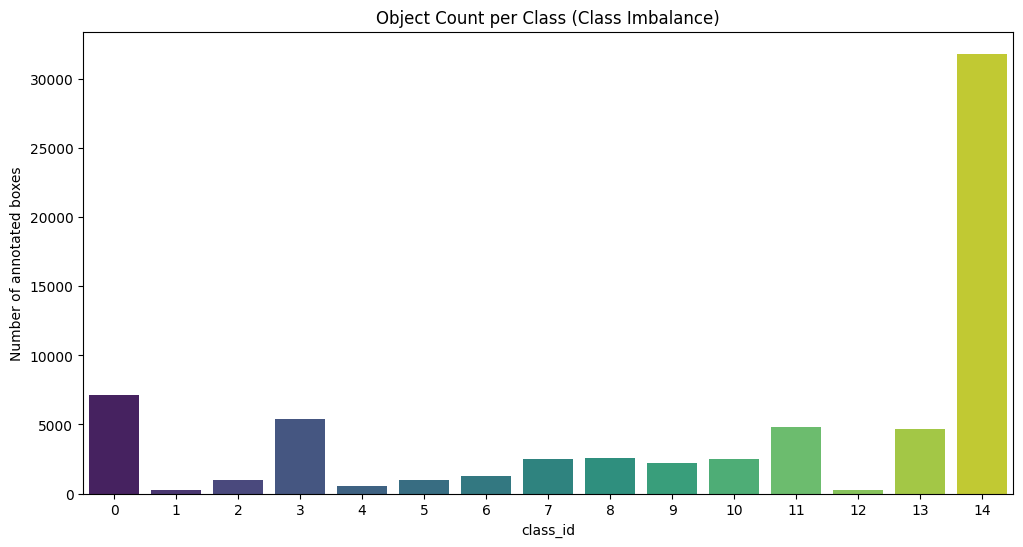

In [11]:
plt.figure(figsize=(12,6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title("Object Count per Class (Class Imbalance)")
plt.xlabel("class_id")
plt.ylabel("Number of annotated boxes")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


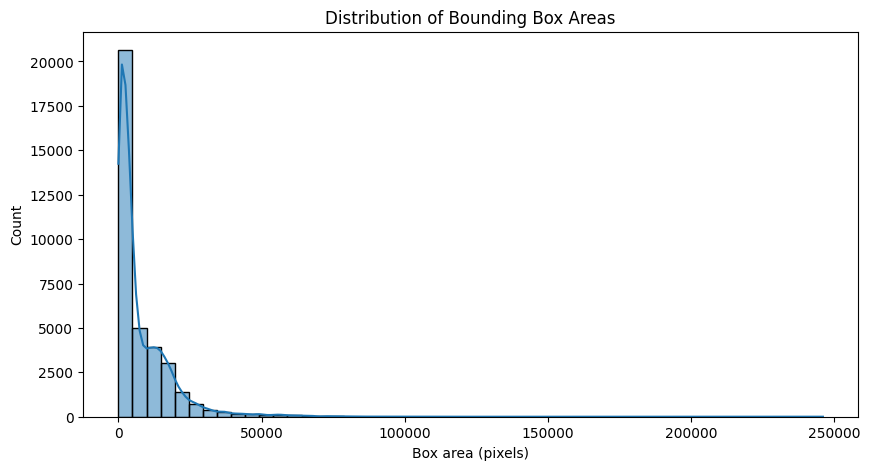

In [12]:
train_df['box_w'] = train_df['x_max'] - train_df['x_min']
train_df['box_h'] = train_df['y_max'] - train_df['y_min']
train_df['box_area'] = train_df['box_w'] * train_df['box_h']

plt.figure(figsize=(10,5))
sns.histplot(train_df['box_area'], bins=50, kde=True)
plt.title("Distribution of Bounding Box Areas")
plt.xlabel("Box area (pixels)")
plt.ylabel("Count")
plt.show()


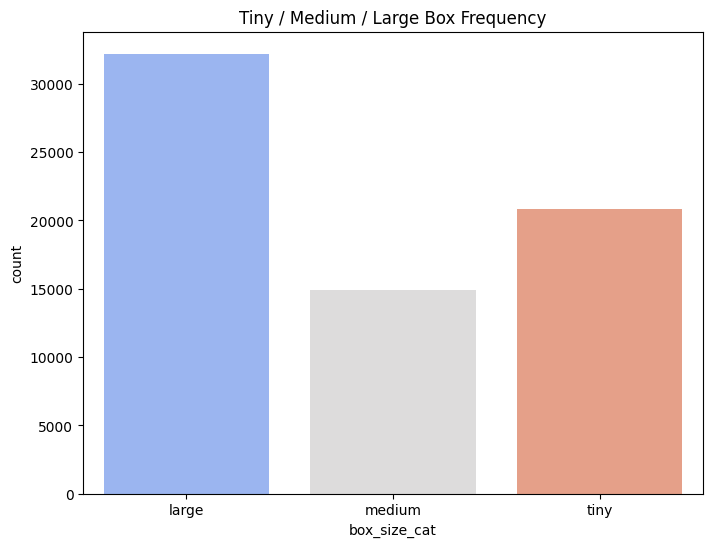

In [13]:
import numpy as np

def categorize_area(a):
    if a < 5000:
        return "tiny"
    elif a < 50000:
        return "medium"
    else:
        return "large"

train_df['box_size_cat'] = train_df['box_area'].apply(categorize_area)

plt.figure(figsize=(8,6))
sns.countplot(data=train_df, x='box_size_cat', palette='coolwarm')
plt.title("Tiny / Medium / Large Box Frequency")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


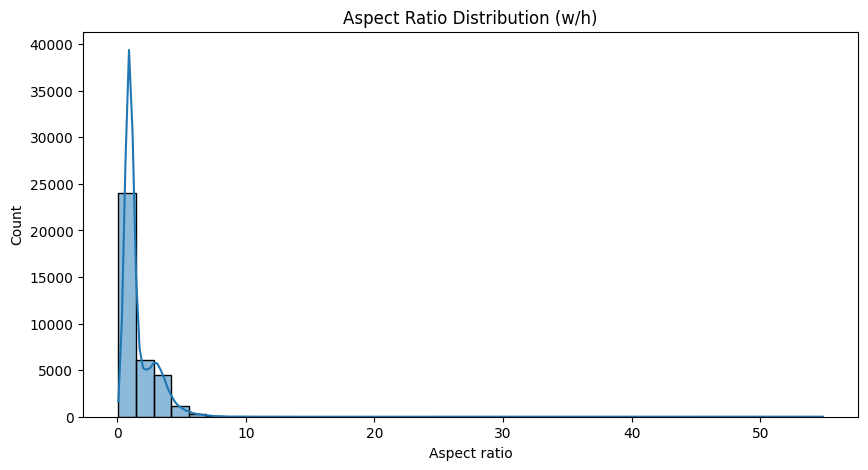

In [14]:
train_df['aspect_ratio'] = train_df['box_w'] / train_df['box_h']

plt.figure(figsize=(10,5))
sns.histplot(train_df['aspect_ratio'], bins=40, kde=True)
plt.title("Aspect Ratio Distribution (w/h)")
plt.xlabel("Aspect ratio")
plt.show()


In [20]:
import os
import pandas as pd

DATA_DIR = "/kaggle/input/vinbigdatachestxrayabnormalities512x512jp2/vinbigdata-chest-xray-abnormalities-detection-512x512-jp2"

train_meta_path = os.path.join(DATA_DIR, "train_meta.csv")

train_meta = pd.read_csv(train_meta_path)
print("train_meta shape:", train_meta.shape)
train_meta.head()


train_meta shape: (15000, 3)


image_id  dim0  dim1
0  4d390e07733ba06e5ff07412f09c0a92  3000  3000
1  289f69f6462af4933308c275d07060f0  3072  3072
2  68335ee73e67706aa59b8b55b54b11a4  2836  2336
3  7ecd6f67f649f26c05805c8359f9e528  2952  2744
4  2229148faa205e881cf0d932755c9e40  2880  2304

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


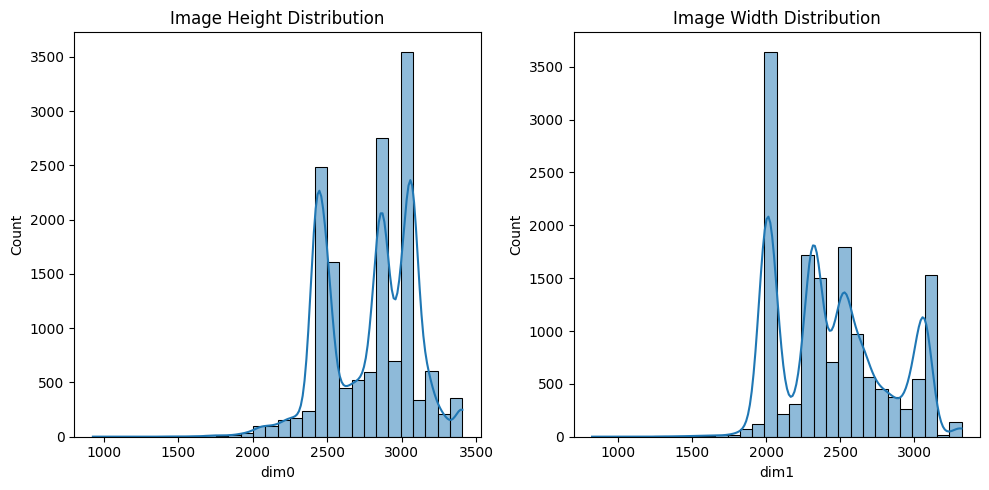

Unique Heights: 1127
Unique Widths: 1036


In [21]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(train_meta['dim0'], kde=True, bins=30)
plt.title("Image Height Distribution")

plt.subplot(1,2,2)
sns.histplot(train_meta['dim1'], kde=True, bins=30)
plt.title("Image Width Distribution")

plt.tight_layout()
plt.show()

print("Unique Heights:", train_meta['dim0'].nunique())
print("Unique Widths:", train_meta['dim1'].nunique())


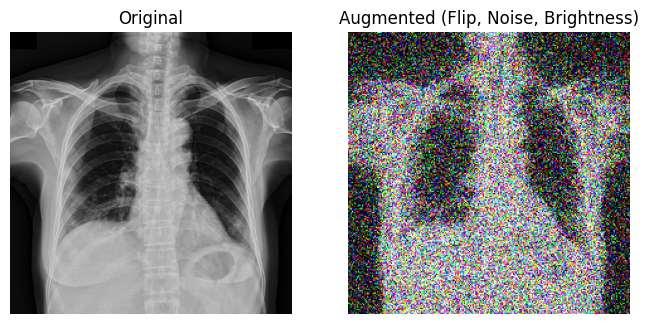

In [16]:
import cv2
import random
from albumentations import (
    Compose, HorizontalFlip, RandomBrightnessContrast, GaussNoise, Resize
)
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

aug = Compose([
    Resize(224,224),
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.5),
    GaussNoise(p=0.3)
])

def show_aug(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    augmented = aug(image=img)['image']
    
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(augmented)
    plt.title("Augmented (Flip, Noise, Brightness)")
    plt.axis("off")

# pick a random abnormal image
sample_img = train_df[train_df['class_id'] != 14]['image_id'].sample(1).values[0]
sample_path = f"{TRAIN_IMG_DIR}/{sample_img}.jp2"

show_aug(sample_path)


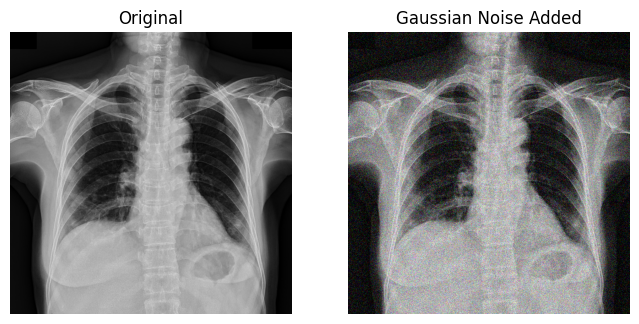

In [17]:
import numpy as np

def add_gaussian_noise(img, sigma=25):
    noise = np.random.normal(0, sigma, img.shape)
    noisy = np.clip(img + noise, 0, 255).astype(np.uint8)
    return noisy

img = cv2.imread(sample_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
noisy = add_gaussian_noise(img)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(noisy)
plt.title("Gaussian Noise Added")
plt.axis("off")
plt.show()


In [1]:
import os
import pandas as pd

DATA_DIR = "/kaggle/input/vinbigdatachestxrayabnormalities512x512jp2/vinbigdata-chest-xray-abnormalities-detection-512x512-jp2"
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train")
TEST_IMG_DIR  = os.path.join(DATA_DIR, "test")

train_csv_path = os.path.join(DATA_DIR, "train.csv")
train_df = pd.read_csv(train_csv_path)
print(train_df.shape)
train_df.head()

(67914, 11)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Unnamed: 0                          image_id          class_name  class_id  \
0           0  50a418190bc3fb1ef1633bf9678929b3          No finding        14   
1           1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14   
2           2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3   
3           3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0   
4           4  063319de25ce7edb9b1c6b8881290140          No finding        14   

  rad_id   x_min   y_min   x_max   y_max  width  height  
0    R11     NaN     NaN     NaN     NaN   2332    2580  
1     R7     NaN     NaN     NaN     NaN   2954    3159  
2    R10  170.09  301.37  406.89  401.32   2080    2336  
3    R10  280.89  132.09  358.00  181.16   2304    2880  
4    R10     NaN     NaN     NaN     NaN   2540    3072

In [2]:
# Binary label per image: 1 = Abnormal, 0 = Normal
# If ALL boxes for that image are class_id == 14 -> Normal (0)
# Else -> Abnormal (1)

def make_binary_label(group):
    # group: all rows for one image_id
    if (group["class_id"] == 14).all():
        return 0
    else:
        return 1

image_labels = train_df.groupby("image_id").apply(make_binary_label).reset_index()
image_labels.columns = ["image_id", "label"]
image_labels["label_name"] = image_labels["label"].map({0: "Normal", 1: "Abnormal"})

print(image_labels["label"].value_counts())
image_labels.head()


label
0    10606
1     4394
Name: count, dtype: int64


/tmp/ipykernel_47/1621513209.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_labels = train_df.groupby("image_id").apply(make_binary_label).reset_index()


image_id  label label_name
0  000434271f63a053c4128a0ba6352c7f      0     Normal
1  00053190460d56c53cc3e57321387478      0     Normal
2  0005e8e3701dfb1dd93d53e2ff537b6e      1   Abnormal
3  0006e0a85696f6bb578e84fafa9a5607      0     Normal
4  0007d316f756b3fa0baea2ff514ce945      1   Abnormal

In [3]:
from sklearn.model_selection import train_test_split

image_labels["image_path"] = image_labels["image_id"].apply(
    lambda x: os.path.join(TRAIN_IMG_DIR, x + ".jp2")
)

# remove any missing files (just in case)
image_labels = image_labels[image_labels["image_path"].apply(os.path.exists)]
print("After path check:", image_labels.shape)

train_df_cls, val_df_cls = train_test_split(
    image_labels,
    test_size=0.15,
    random_state=42,
    stratify=image_labels["label"]
)

print("Train:", len(train_df_cls), "Val:", len(val_df_cls))
train_df_cls.head()


After path check: (15000, 4)
Train: 12750 Val: 2250


image_id  label label_name  \
4882   53f24abf8ff03943c9a413462606cb39      0     Normal   
7209   7b85671c74690ec283810c7ea3265405      0     Normal   
13148  dee1d690aeff154df7ee9cc5017ae8f7      0     Normal   
12202  cfb0f1134227a67c3c30809e424fba01      1   Abnormal   
3685   3ef799c210c419c0319cd2555eaa3abe      0     Normal   

                                              image_path  
4882   /kaggle/input/vinbigdatachestxrayabnormalities...  
7209   /kaggle/input/vinbigdatachestxrayabnormalities...  
13148  /kaggle/input/vinbigdatachestxrayabnormalities...  
12202  /kaggle/input/vinbigdatachestxrayabnormalities...  
3685   /kaggle/input/vinbigdatachestxrayabnormalities...

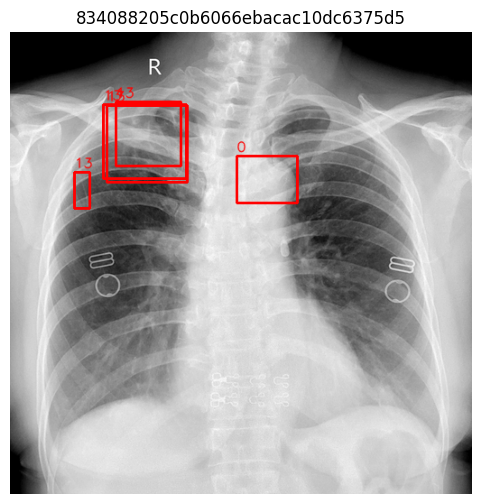

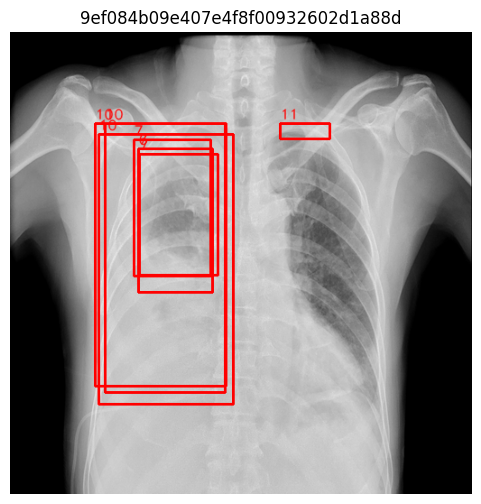

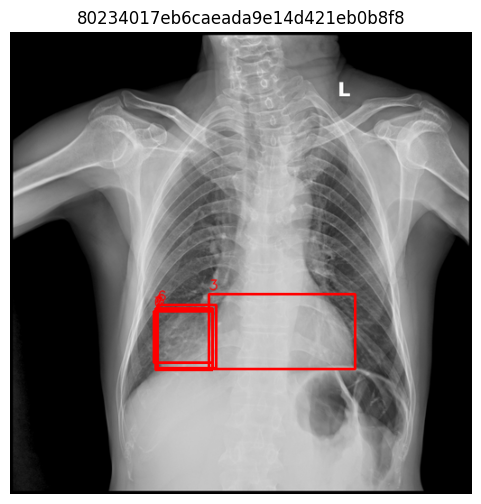

In [4]:
import cv2
import matplotlib.pyplot as plt

def show_image_with_boxes(image_id):
    img_path = os.path.join(TRAIN_IMG_DIR, image_id + ".jp2")
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    rows = train_df[train_df["image_id"] == image_id]

    for _, r in rows.iterrows():
        x_min, y_min, x_max, y_max = int(r["x_min"]), int(r["y_min"]), int(r["x_max"]), int(r["y_max"])
        class_id = int(r["class_id"])
        # skip no-finding boxes (if any)
        if class_id == 14:
            continue
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255,0,0), 2)
        cv2.putText(img, str(class_id), (x_min, y_min-5), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (255,0,0), 1, cv2.LINE_AA)

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{image_id}")
    plt.show()

# Show a few abnormal images
abnormal_ids = image_labels[image_labels["label"] == 1]["image_id"].sample(3, random_state=0).tolist()
for iid in abnormal_ids:
    show_image_with_boxes(iid)


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Albumentations if available
try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    use_alb = True
    print("Using Albumentations")
except:
    use_alb = False
    from torchvision import transforms as T
    print("Using Torchvision transforms")

if use_alb:
    train_tf = A.Compose([
        A.Resize(224,224),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(),
        ToTensorV2()
    ])
    val_tf = A.Compose([
        A.Resize(224,224),
        A.Normalize(),
        ToTensorV2()
    ])
else:
    train_tf = T.Compose([
        T.ToPILImage(),
        T.Resize((224,224)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize([0.5]*3,[0.5]*3)
    ])
    val_tf = T.Compose([
        T.ToPILImage(),
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize([0.5]*3,[0.5]*3)
    ])

class VinBigClsDataset(Dataset):
    def __init__(self, df, tf):
        self.df = df.reset_index(drop=True)
        self.tf = tf
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        img = cv2.imread(r["image_path"], cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if use_alb:
            img = self.tf(image=img)["image"]
        else:
            img = self.tf(img)
        label = int(r["label"])
        return img, label

train_ds = VinBigClsDataset(train_df_cls, train_tf)
val_ds   = VinBigClsDataset(val_df_cls, val_tf)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)

xb, yb = next(iter(train_loader))
print("Batch:", xb.shape, yb.shape)


Using Albumentations
Batch: torch.Size([16, 3, 224, 224]) torch.Size([16])


In [6]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

n_classes = 2  # Normal vs Abnormal

try:
    import timm
    model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=n_classes)
    print("Using EfficientNet-B0 (timm)")
except:
    from torchvision import models
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, n_classes)
    print("Using ResNet50")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Device: cuda


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s] 


Using ResNet50


In [7]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

def evaluate(model, loader):
    model.eval()
    ys, preds, probs = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            p = torch.softmax(out, dim=1).cpu().numpy()
            preds.extend(p.argmax(axis=1).tolist())
            ys.extend(yb.cpu().numpy().tolist())
            probs.extend(p.tolist())
    metrics = {
        "acc": accuracy_score(ys, preds),
        "f1": f1_score(ys, preds, average="macro")
    }
    try:
        metrics["auc"] = roc_auc_score(ys, np.array(probs)[:,1])
    except:
        metrics["auc"] = None
    return metrics

EPOCHS = 5
best_auc = 0.0
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    val_metrics = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {running_loss/len(train_loader):.4f} | Val: {val_metrics}")
    if val_metrics["auc"] is not None and val_metrics["auc"] > best_auc:
        best_auc = val_metrics["auc"]
        torch.save(model.state_dict(), "/kaggle/working/vinbig_cls_model.pth")
        print("Saved best model.")
print("Best AUC:", best_auc)


Epoch 1/5 | Loss: 0.2472 | Val: {'acc': 0.9342222222222222, 'f1': 0.9196571265335114, 'auc': 0.9813213361577691}
Saved best model.
Epoch 2/5 | Loss: 0.1809 | Val: {'acc': 0.9377777777777778, 'f1': 0.9258630947897996, 'auc': 0.9834072347394152}
Saved best model.
Epoch 3/5 | Loss: 0.1527 | Val: {'acc': 0.9293333333333333, 'f1': 0.9163300965378784, 'auc': 0.9796169462330313}
Epoch 4/5 | Loss: 0.1277 | Val: {'acc': 0.8897777777777778, 'f1': 0.8773584325088948, 'auc': 0.9839423006307291}
Saved best model.
Epoch 5/5 | Loss: 0.1129 | Val: {'acc': 0.9324444444444444, 'f1': 0.9145341863254699, 'auc': 0.9824315263493724}
Best AUC: 0.9839423006307291


Device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded weights from: /kaggle/working/vinbig_cls_model.pth
Grad-CAM will run on 6 images


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


[0] 70eb6d92bf0c7e35e0d55e17d00629fa.jp2 -> pred: 1 saved: /kaggle/working/gradcam_0.png
[1] b80be20a79e5a7539bd00f4907b444b2.jp2 -> pred: 1 saved: /kaggle/working/gradcam_1.png
[2] fec797e0e4b2eff050372800790c01e8.jp2 -> pred: 1 saved: /kaggle/working/gradcam_2.png
[3] 884a48f5d51b49d99b0023db326e0f14.jp2 -> pred: 0 saved: /kaggle/working/gradcam_3.png
[4] bf4c374e944d7f8e92618be98703f46c.jp2 -> pred: 0 saved: /kaggle/working/gradcam_4.png
[5] ee0d65c2402ce79f2d7a66502b3ca321.jp2 -> pred: 0 saved: /kaggle/working/gradcam_5.png
Saved grid to: /kaggle/working/gradcam_grid.png


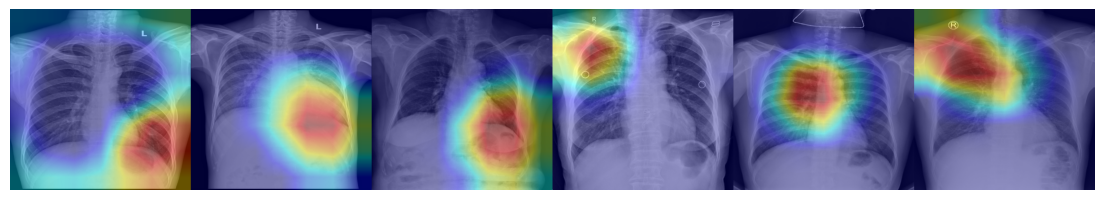

In [9]:

import os, glob, cv2, numpy as np, torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# 1) Build ResNet50 architecture (same as training)
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # binary

# 2) Try to load checkpoint (tries common paths)
candidate_paths = [
    "/kaggle/working/resnet50_vinbig_cls.pth",
    "/kaggle/working/vinbig_cls_model.pth",
    "/kaggle/working/classification_model.pth",
    "/kaggle/working/resnet50_vinbig_cls.pth",
    "/kaggle/working/resnet50.pth"
]
loaded = False
for p in candidate_paths:
    if os.path.exists(p):
        try:
            state = torch.load(p, map_location=device)
            # handle both state dict or wrapped dict
            if isinstance(state, dict) and ("state_dict" in state and isinstance(state["state_dict"], dict)):
                sd = state["state_dict"]
            else:
                sd = state
            model.load_state_dict(sd, strict=False)
            print("Loaded weights from:", p)
            loaded = True
            break
        except Exception as e:
            try:
                # try loading with CPU first then to device
                model.load_state_dict(torch.load(p, map_location="cpu"), strict=False)
                print("Loaded weights (cpu-load) from:", p)
                loaded = True
                break
            except Exception as e2:
                print("Tried", p, "-> failed:", e)
if not loaded:
    print("Warning: No ResNet50 checkpoint found in expected paths. The model will be uninitialized (random).")

model = model.to(device).eval()

# 3) Target layer (ResNet50 last conv)
target_layer = model.layer4[2].conv3

# 4) hooks storage
activations = None
gradients = None

def forward_hook(module, inp, out):
    global activations
    activations = out  # tensor on device

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]  # tensor on device

# register hooks
h_f = target_layer.register_forward_hook(forward_hook)
h_b = target_layer.register_backward_hook(backward_hook)

# 5) Preprocess
tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# 6) Select sample images from val set (3 abnormal + 3 normal if possible)
# expects val_df_cls to exist in the notebook (from earlier cells)
out_dir = "/kaggle/working"
os.makedirs(out_dir, exist_ok=True)

samples = []
if 'val_df_cls' in globals():
    try:
        abnormal = val_df_cls[val_df_cls['label']==1]
        normal = val_df_cls[val_df_cls['label']==0]
        n_ab = min(3, len(abnormal))
        n_no = min(3, len(normal))
        samples += list(abnormal.sample(n_ab, random_state=1)['image_path'].tolist())
        samples += list(normal.sample(n_no, random_state=2)['image_path'].tolist())
    except Exception as e:
        print("Could not sample from val_df_cls:", e)
# fallback: pick any images from working folder
if len(samples) == 0:
    imgs = sorted(glob.glob(os.path.join("/kaggle/working/images_png","*.png")))
    imgs2 = imgs[:6]
    samples = imgs2

print("Grad-CAM will run on", len(samples), "images")

# helper to compute CAM for one image
def compute_gradcam(img_path, idx):
    global activations, gradients
    activations = None
    gradients = None

    img_pil = Image.open(img_path).convert("RGB")
    inp = tf(img_pil).unsqueeze(0).to(device)

    # forward
    out = model(inp)
    pred = out.argmax(dim=1).item()

    # backward from predicted class score
    model.zero_grad()
    score = out[0, pred]
    score.backward(retain_graph=False)

    # get activations and gradients (device tensors)
    act = activations.detach().cpu().numpy()[0]   # (C, H, W)
    grad = gradients.detach().cpu().numpy()[0]   # (C, H, W)

    # weights: global average pooling of gradients
    weights = np.mean(grad, axis=(1,2))  # (C,)

    cam = np.zeros(act.shape[1:], dtype=np.float32)  # (H, W)
    for i, w in enumerate(weights):
        cam += w * act[i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (img_pil.size[0], img_pil.size[1]))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    img_np = np.array(img_pil)[:,:,::-1]  # RGB->BGR for cv2
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    out_path = os.path.join(out_dir, f"gradcam_{idx}.png")
    cv2.imwrite(out_path, overlay)
    return out_path, pred

# run over samples
saved_paths = []
for i, p in enumerate(samples):
    try:
        out_path, pred = compute_gradcam(p, i)
        print(f"[{i}] {os.path.basename(p)} -> pred: {pred} saved: {out_path}")
        saved_paths.append(out_path)
    except Exception as e:
        print("Failed on", p, "->", e)

# remove hooks
h_f.remove(); h_b.remove()

# create a grid image
if len(saved_paths) > 0:
    imgs = [cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB) for x in saved_paths]
    # resize to same height
    h = 320
    imgs_rs = [cv2.resize(im, (int(im.shape[1]*h/im.shape[0]), h)) for im in imgs]
    total_w = sum(im.shape[1] for im in imgs_rs)
    grid = np.ones((h, total_w, 3), dtype=np.uint8) * 255
    x = 0
    for im in imgs_rs:
        grid[:, x:x+im.shape[1], :] = im
        x += im.shape[1]
    grid_path = os.path.join(out_dir, "gradcam_grid.png")
    cv2.imwrite(grid_path, cv2.cvtColor(grid, cv2.COLOR_RGB2BGR))
    print("Saved grid to:", grid_path)
    # display
    from matplotlib import pyplot as plt
    plt.figure(figsize=(14,6))
    plt.imshow(grid)
    plt.axis("off")
    plt.show()
else:
    print("No Grad-CAM images were created.")
